In [1]:
import pandas as pd
import numpy as np
import pathlib
import datetime
from datetime import datetime, timedelta, date
from rich import print
from collections import namedtuple
from dataclasses import dataclass, asdict
import operator

import tomllib
import tomlkit as tml
import json
import xarray as xr
import csvb.ingest as ci
import plotly.express as px
import plotly.graph_objects as go
from collections import namedtuple
#from decimal import Decimal, getcontext

#getcontext().prec = 2
pd.options.mode.copy_on_write = True
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
Transaction = namedtuple("Transaction", ["Date", "Amount", "From", "To", "Description", "Notes"], defaults=[""])

In [3]:
HOME = pathlib.Path.home()
cfgpth = HOME / ".config" / "csvb" / "config.toml"
with open(cfgpth, 'rb') as f:
    cfg = tomllib.load(f)
RULESPTH = HOME / cfg["paths"]["rules"]
BANKPTH = HOME / cfg["paths"]["bank"]
PRODUCTSPTH = HOME / cfg["paths"]["products"]
ACCT_NAMES = ["Type", "Account", "Subaccount"]
INST_ACCOUNTS = ["Assets:1st Source:Checking",
                 "Assets:Fidelity:HSA",
                 "Assets:Ally:Savins",
                 "Liabilities:NDFCU:Credit Card",
                 "Liabilities:Apple:Credit Card",
                 "Liabilities:Apple:Installments"]

In [4]:
fd  = ci.find_bank_files(HOME / pathlib.Path(cfg["paths"]["bank"])) 

In [5]:
try:
    del apl
except NameError:
    pass
apl = ci.ingest_bank_files(fd["Liabilities:Apple:Credit Card"]["files"],
                           fd["Liabilities:Apple:Credit Card"],
                           RULESPTH)

apl = ci.read_and_apply(apl, RULESPTH / fd["Liabilities:Apple:Credit Card"]["rules_file"])
apl[apl["From"] == ""]
#np.max(apl["Transaction Date"])

Empty DataFrame
Columns: [Transaction Date, Clearing Date, Description, Merchant, Category, Type, Amount (USD), Purchased By, Amount, From]
Index: []

In [6]:
try:
    del apl_inc
except NameError:
    pass
apl_inc = ci.ingest_bank_files(fd["Liabilities:Apple:Installments"]["files"],
                           fd["Liabilities:Apple:Installments"],
                           RULESPTH)

apl_inc[apl_inc["From"] == ""]
apl_inc.loc[4, "From"] = "Liabilities:Apple:Credit Card"
apl_inc



Date                                        Description    Amount  \
0 2022-05-20  iPhone - Apple Store MISHAWAKA IN TRANSACTION ... -1,299.00   
1 2022-05-20  iPhone AppleCare - Apple Store MISHAWAKA IN TR...   -199.00   
2 2024-02-09  Mac Pro M3 - Apple Online Store Cupertino CA T... -1,369.00   
3 2024-02-09  Mac Pro M3 AppleCare - Apple Online Store Cupe...   -279.00   
4 2022-05-31                               Manual Iphone Payoff    414.12   

                            From  
0           Expenses:Electronics  
1           Expenses:Electronics  
2           Expenses:Electronics  
3           Expenses:Electronics  
4  Liabilities:Apple:Credit Card

In [7]:
try:
    del fst
except NameError:
    pass
fst = ci.ingest_bank_files(fd["Assets:1st Source:Checking"]["files"],
                           fd["Assets:1st Source:Checking"],
                           RULESPTH)

fst = ci.read_and_apply(fst, RULESPTH / fd["Assets:1st Source:Checking"]["rules_file"])

fst[fst["From"] == ""]
#fst["Date"].max()

Empty DataFrame
Columns: [Transaction Number, Date, Description, Memo, Amount Debit, Amount Credit, Balance, Amount, From, Check Number, Fees  ]
Index: []

In [8]:
try:
    del ally
except NameError:
    pass
ally = ci.ingest_bank_files(fd["Assets:Ally:Savings"]["files"],
                           fd["Assets:Ally:Savings"],
                           RULESPTH)

ally = ci.read_and_apply(ally, RULESPTH / fd["Assets:Ally:Savings"]["rules_file"])

ally[ally["From"] == ""]
#ally.sort_values("Date")
#fd["Assets:Ally:Savings"]

Empty DataFrame
Columns: [Date, Time, Amount, Type, Description, From]
Index: []

In [9]:
try:
    del ndfcu
except NameError:
    pass
ndfcu = ci.ingest_bank_files(fd["Liabilities:NDFCU:Credit Card"]["files"],
                           fd["Liabilities:NDFCU:Credit Card"],
                           RULESPTH)

ndfcu = ci.read_and_apply(ndfcu, RULESPTH / fd["Liabilities:NDFCU:Credit Card"]["rules_file"])

ndfcu["Description"] = ndfcu["Description"].fillna("")

#ndfcu[ndfcu["From"] == ""]
ndfcu[pd.isnull(ndfcu["From"])]

Empty DataFrame
Columns: [Date, Note, Description, Amount, Balance, From]
Index: []

In [10]:
try:
    del hsa
except NameError:
    pass
hsa = ci.ingest_bank_files(fd["Assets:Fidelity:HSA"]["files"],
                           fd["Assets:Fidelity:HSA"],
                           RULESPTH)
hsa = hsa.rename(columns={"Run Date": "Date",
                          "Action": "Description",
                          "Description": "Note",
                          "Amount ($)": "Amount",
                          
                         }
                )

hsa = ci.read_and_apply(hsa, RULESPTH / fd["Assets:Fidelity:HSA"]["rules_file"])
hsa[hsa["From"] == ""]

Empty DataFrame
Columns: [Date, Description, Symbol, Note, Type, Quantity, Price ($), Commission ($), Fees ($), Accrued Interest ($), Amount, Cash Balance ($), Settlement Date, From]
Index: []

In [11]:
bank_tables = {"Assets:1st Source:Checking": fst,
               "Liabilities:Apple:Credit Card": apl.rename(columns={"Transaction Date": "Date"}),
              "Assets:Ally:Savings": ally,
              "Liabilities:NDFCU:Credit Card": ndfcu,
              "Liabilities:Apple:Installments": apl_inc,
              "Assets:Fidelity:HSA": hsa}


trans = ci.to_transactions(bank_tables)
trans = trans.sort_values("Date")

In [12]:
try:
    del bal_decl
except NameError:
    pass

bal_decl = pd.read_csv(HOME / pathlib.Path(cfg["paths"]["bank"]) / "balances.csv",
                  header=0,
                  parse_dates=["Date"])
bal_decl

Date                         Account  Statement Balance
0  2024-08-31  Liabilities:Apple:Installments            -824.02
1  2024-08-31   Liabilities:Apple:Credit Card          -3,424.48
2  2024-04-18             Assets:Ally:Savings          11,604.81
3  2024-03-18             Assets:Ally:Savings          10,965.45
4  2024-02-18             Assets:Ally:Savings          10,330.00
5  2024-04-30   Liabilities:NDFCU:Credit Card            -501.39
6  2024-03-31   Liabilities:NDFCU:Credit Card          -1,570.40
7  2024-02-29   Liabilities:NDFCU:Credit Card          -1,758.27
8  2024-01-31   Liabilities:NDFCU:Credit Card          -1,565.79
9  2024-01-31             Assets:Fidelity:HSA           3,956.09
10 2024-08-31             Assets:Fidelity:HSA           6,524.05
11 2024-01-30      Assets:1st Source:Checking           1,297.66
12 2024-08-29      Assets:1st Source:Checking             622.49
13 2024-07-30      Assets:1st Source:Checking           8,365.45
14 2024-01-18             Assets:Ally:Savings           9,694.18
15 2022-12-07             Assets:Ally:Savings               0.00
16 2023-12-31   Liabilities:NDFCU:Credit Card             -99.77
17 2024-08-31   Liabilities:NDFCU:Credit Card          -1,315.17
18 2023-12-31  Liabilities:Apple:Installments            -312.21
19 2023-12-31   Liabilities:Apple:Credit Card            -284.77
20 2023-12-31             Assets:Fidelity:HSA           3,939.33
21 2022-12-31             Assets:Fidelity:HSA               0.00
22 2023-12-31      Assets:1st Source:Checking           2,320.59
23 2023-12-18             Assets:Ally:Savings          10,058.08
24 2024-08-18             Assets:Ally:Savings           1,495.04
25 2023-11-30   Liabilities:NDFCU:Credit Card          -2,085.08
26 2023-11-30   Liabilities:NDFCU:Credit Card          -2,085.08
27 2023-11-30  Liabilities:Apple:Installments            -374.62
28 2023-11-30   Liabilities:Apple:Credit Card            -201.50
29 2023-11-18             Assets:Ally:Savings           9,425.23
30 2023-10-31   Liabilities:NDFCU:Credit Card          -2,492.89
31 2023-10-31  Liabilities:Apple:Installments            -437.03
32 2023-10-31   Liabilities:Apple:Credit Card            -151.48
33 2023-10-18             Assets:Ally:Savings           8,793.47
34 2023-09-30   Liabilities:NDFCU:Credit Card          -1,581.47
35 2023-08-31   Liabilities:NDFCU:Credit Card             -69.79
36 2023-07-31   Liabilities:NDFCU:Credit Card          -3,172.26
37 2023-06-30   Liabilities:NDFCU:Credit Card          -1,409.14
38 2023-05-31   Liabilities:NDFCU:Credit Card            -351.48
39 2023-04-30   Liabilities:NDFCU:Credit Card          -3,924.01
40 2023-03-31   Liabilities:NDFCU:Credit Card          -2,519.52
41 2023-02-28   Liabilities:NDFCU:Credit Card            -885.51
42 2023-01-31   Liabilities:NDFCU:Credit Card          -1,376.20
43 2022-12-31   Liabilities:NDFCU:Credit Card             -76.69
44 2021-12-31   Liabilities:NDFCU:Credit Card          -1,694.49
45 2022-01-01           Liabilities:Auto:Loan          -4,216.71
46 2021-12-31  Liabilities:Apple:Installments            -552.08
47 2021-12-31   Liabilities:Apple:Credit Card          -2,522.77
48 2021-12-31      Assets:1st Source:Checking           5,067.54
49 2021-12-31             Assets:Ally:Savings           8,028.68

In [13]:
trans = pd.concat([trans, ci.gen_init_balance_trans(bal_decl)], ignore_index=True).sort_values("Date")
#trans[trans["To"] == "Assets:Fidelity:HSA"]

In [20]:
try:
    del ledgers
except NameError:
    pass
    
#ledgers = create_ledgers(trans)
#ledgers = ci.trans_to_ledgers(trans, bal_decl=bal_decl)
#ledgers[ledgers["Account"] == "Assets:1st Source:Checking"]
#ledgers[ledgers["Transaction Pair"] == "Liabilities:Auto:Loan"]
fg = trans.groupby("From")
tg = trans.groupby("To")
fl = {}
for acct in fg.groups:
    fl[acct] = trans.loc[fg.groups[acct]][["Date", "Description", "To"]].rename(columns={"To": "Transaction Pair"})
                                                                                                       
    fl[acct]["Incoming Amount"] = - 1 * trans.loc[fg.groups[acct]]["Amount"]
    fl[acct]["Account String"] = [acct] * len(fl[acct])

tl = {}
for acct in tg.groups:
    tl[acct] = trans.loc[tg.groups[acct]][["Date", "Description", "From"]].rename(columns={"From": "Transaction Pair"})
                                                                                                       
    tl[acct]["Incoming Amount"] = trans.loc[tg.groups[acct]]["Amount"]
    tl[acct]["Account String"] = [acct] * len(tl[acct])

ledgers = pd.concat(list(tl.values()) + list(fl.values())).sort_values("Date", ignore_index=True)

# Split account string to tuples.
acct_tuples = ledgers["Account String"].apply(lambda t:ci.to_triple(t, fill="")).apply(pd.Series).rename(columns=dict(zip(range(3), ACCT_NAMES)))
ledgers = pd.concat([ledgers, acct_tuples], axis="columns")

# Calculate cumulative balance.
ledgers["Balance"] = ledgers.groupby("Account String")["Incoming Amount"].cumsum()
ledgers[ledgers["Account String"] == "Liabilities:Apple:Installments"]

Date                      Description  \
10   2021-12-31                  Initial Balance   
139  2022-01-31   MONTHLY INSTALLMENTS (9 OF 24)   
140  2022-01-31   MONTHLY INSTALLMENTS (9 OF 24)   
256  2022-02-28  MONTHLY INSTALLMENTS (10 OF 24)   
257  2022-02-28  MONTHLY INSTALLMENTS (10 OF 24)   
...         ...                              ...   
5568 2024-06-30   MONTHLY INSTALLMENTS (5 OF 12)   
5758 2024-07-31   MONTHLY INSTALLMENTS (6 OF 12)   
5763 2024-07-31   MONTHLY INSTALLMENTS (6 OF 12)   
5936 2024-08-31   MONTHLY INSTALLMENTS (7 OF 12)   
5938 2024-08-31   MONTHLY INSTALLMENTS (7 OF 12)   

                   Transaction Pair  Incoming Amount  \
10           Equity:Initial Balance          -552.08   
139   Liabilities:Apple:Credit Card            28.29   
140   Liabilities:Apple:Credit Card             6.20   
256   Liabilities:Apple:Credit Card            28.29   
257   Liabilities:Apple:Credit Card             6.20   
...                             ...              ...   
5568  Liabilities:Apple:Credit Card            23.25   
5758  Liabilities:Apple:Credit Card           114.08   
5763  Liabilities:Apple:Credit Card            23.25   
5936  Liabilities:Apple:Credit Card            23.25   
5938  Liabilities:Apple:Credit Card           114.08   

                      Account String         Type Account    Subaccount  \
10    Liabilities:Apple:Installments  Liabilities   Apple  Installments   
139   Liabilities:Apple:Installments  Liabilities   Apple  Installments   
140   Liabilities:Apple:Installments  Liabilities   Apple  Installments   
256   Liabilities:Apple:Installments  Liabilities   Apple  Installments   
257   Liabilities:Apple:Installments  Liabilities   Apple  Installments   
...                              ...          ...     ...           ...   
5568  Liabilities:Apple:Installments  Liabilities   Apple  Installments   
5758  Liabilities:Apple:Installments  Liabilities   Apple  Installments   
5763  Liabilities:Apple:Installments  Liabilities   Apple  Installments   
5936  Liabilities:Apple:Installments  Liabilities   Apple  Installments   
5938  Liabilities:Apple:Installments  Liabilities   Apple  Installments   

      Balance  
10    -552.08  
139   -523.79  
140   -517.59  
256   -489.30  
257   -483.10  
...       ...  
5568  -961.35  
5758  -847.27  
5763  -824.02  
5936  -800.77  
5938  -686.69  

[76 rows x 9 columns]

# Ledger Table with Zeros

In [21]:
lw0 = ledgers
#lw0 = lw0.set_index("Date")
daily = pd.date_range(start=lw0["Date"].min(), end=lw0["Date"].max(), freq="1D")
def add_dates(df):
    datesnotin = daily[~daily.isin(df["Date"])]
    newdf = pd.DataFrame({"Date": datesnotin,
                          "Incoming Amount": [0.0] * len(datesnotin),
                          "Description": ["Fake Zero"] * len(datesnotin)
                         })
    newdf = pd.concat([df, newdf]).sort_values("Date")
    #print(newdf)
    cols=["Transaction Pair", "Account String", "Balance"]
    newdf.loc[:, cols]  = newdf.loc[:, cols].ffill()
    newdf.loc[:, ["Transaction Pair", "Account String"]] = newdf.loc[:, ["Transaction Pair", "Account String"]].bfill()
    #print(newdf)
    newdf["Balance"] = newdf["Balance"].fillna(0.0)
    return newdf
    
lw0 = lw0.groupby(ACCT_NAMES).apply(add_dates, include_groups=False)
lw0=lw0.reset_index().drop(columns="level_3").sort_values("Date")

In [22]:
#g = ledge_with_acct["Incoming Amount"].groupby(ledge_with_acct.index).sum("Incoming Amount")
# Select all lines with an initial balance.

clear_virtuals=True

start_date = None
end_date = None #date(2024,1,1)

ltable = ledgers

if start_date is not None:
    ltable = ltable[ltable["Date"] >= pd.Timestamp(start_date)]
if end_date is not None:
    ltable = ltable[ltable["Date"] <= pd.Timestamp(end_date)]


# Group on Accounts
acct_g = ltable.groupby(ACCT_NAMES)

# Choose first and last date of each group from ltable, reassign with column names and set account as multiindex.
start = acct_g.head(1)[["Date", "Balance"] + ACCT_NAMES].rename(columns={"Date": "Start Date", "Balance": "Initial Balance"}).set_index(ACCT_NAMES)
end = acct_g.tail(1)[["Date", "Balance"] + ACCT_NAMES].rename(columns={"Date": "End Date", "Balance": "End Balance"}).set_index(ACCT_NAMES)

#br = br.set_index(pd.MultiIndex.from_tuples(br.index.to_series().apply(ci.to_triple), names=["Type", "Account", "Subaccount"])a
br = pd.concat([start, end],axis="columns")
br["Difference"] = br["End Balance"] - br["Initial Balance"]
br
#acct_g["Date"].groups["Expenses:Reimbursible"]

Start Date  Initial Balance  \
Type     Account         Subaccount                                     
Assets   1st Source      Checking         2021-12-31         5,067.54   
Expenses Entertainment                    2021-12-31            11.04   
         Auto            Fuel             2021-12-31            26.93   
Equity   Initial Balance                  2021-12-31         1,694.49   
Expenses Groceries                        2021-12-31            86.95   
...                                              ...              ...   
Income   Notre Dame      HSA Contribution 2023-02-02          -500.00   
Expenses Medical         Dentist          2023-05-26           114.00   
Income   Rewards                          2023-12-04           -25.50   
Expenses Services                         2024-03-10            59.95   
         Home            Major            2024-08-05         8,284.00   

                                            End Date  End Balance  Difference  
Type     Account         Subaccount                                            
Assets   1st Source      Checking         2024-08-30     6,183.68    1,116.14  
Expenses Entertainment                    2024-08-26     4,162.89    4,151.85  
         Auto            Fuel             2024-08-08     2,135.99    2,109.06  
Equity   Initial Balance                  2022-12-31    -4,110.17   -5,804.66  
Expenses Groceries                        2024-08-28    24,802.89   24,715.94  
...                                              ...          ...         ...  
Income   Notre Dame      HSA Contribution 2024-09-04    -6,583.20   -6,083.20  
Expenses Medical         Dentist          2023-05-26       114.00        0.00  
Income   Rewards                          2024-08-01      -748.37     -722.87  
Expenses Services                         2024-03-10        59.95        0.00  
         Home            Major            2024-08-05     8,284.00        0.00  

[64 rows x 5 columns]

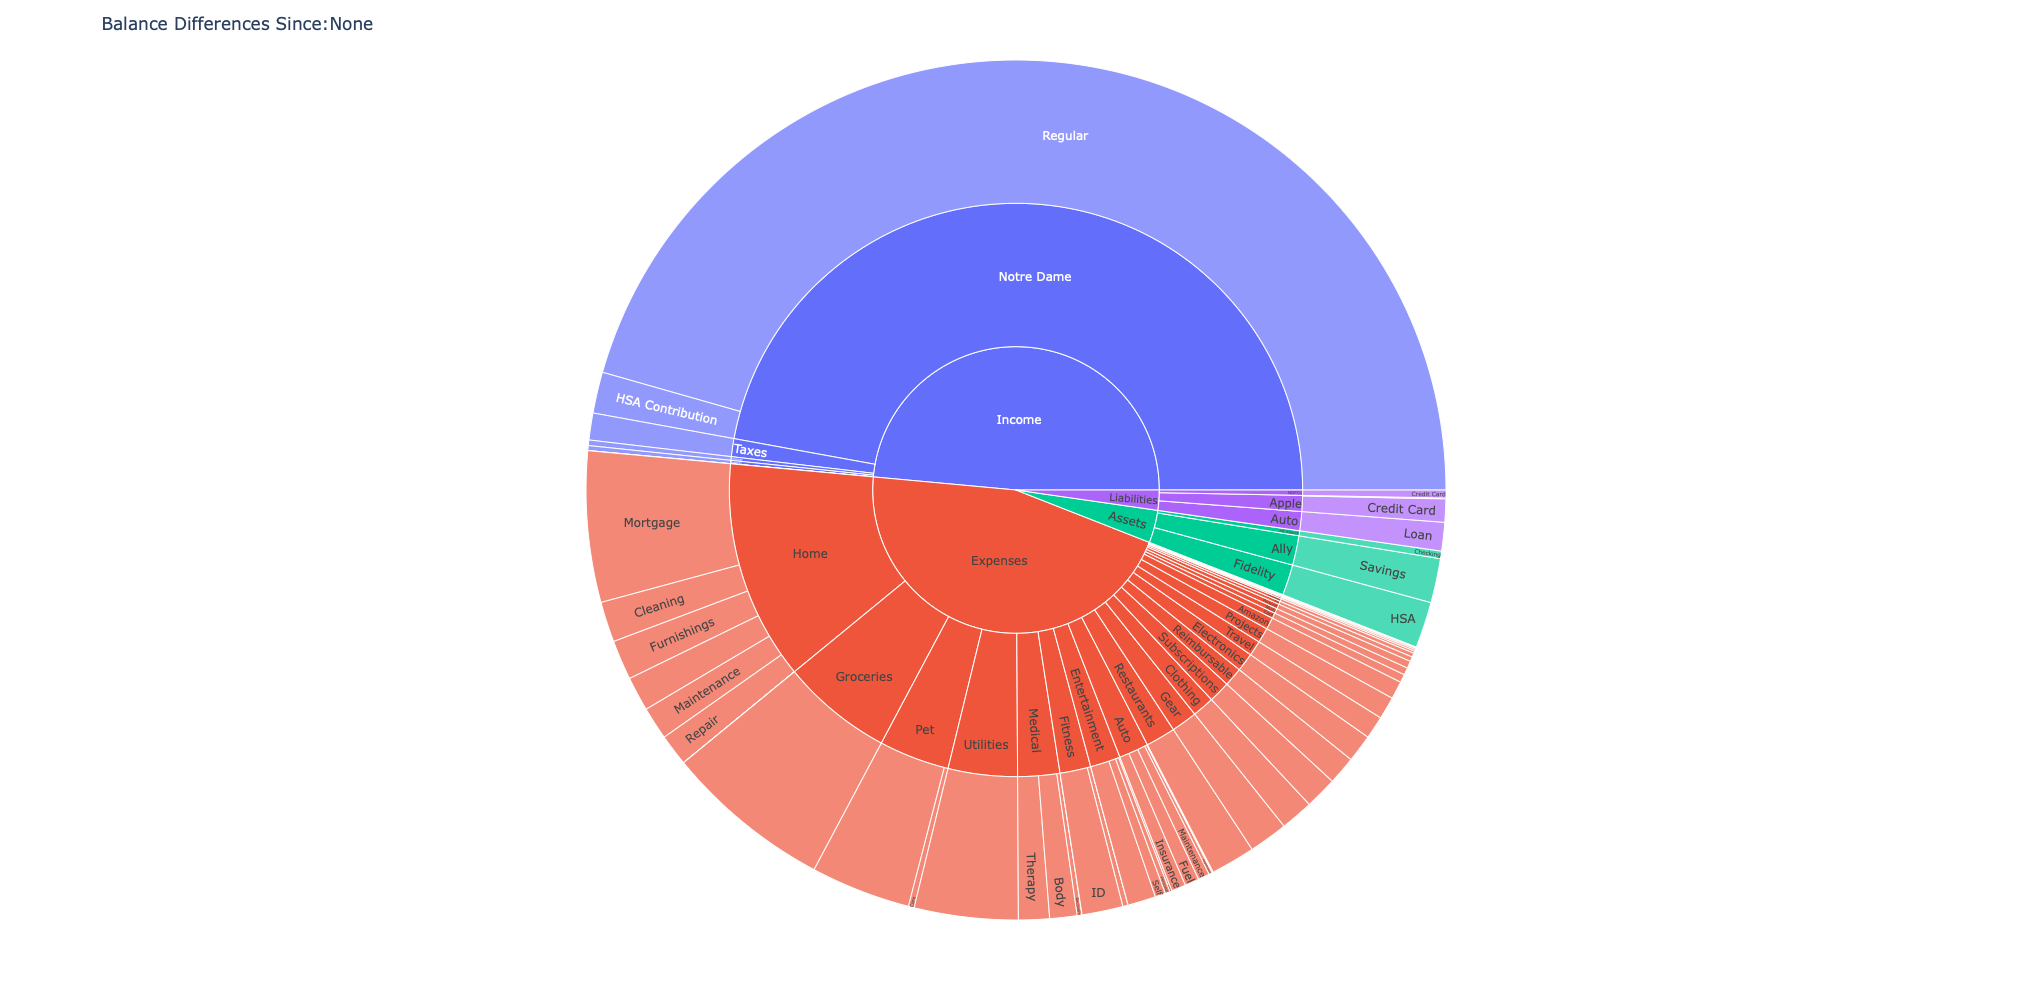

In [23]:
#cutoff_ledgers["Liabilities:Auto:Loan"].iloc[-2:-1]
#cb = ci.balances(ledgers)
#cb
df = br
df = pd.DataFrame({"Type": df.index.get_level_values("Type"),
                   "Account": df.index.get_level_values("Account"),
                   "Subaccount": df.index.get_level_values("Subaccount"),
                   "Difference": df["Difference"].apply(np.abs)})
df = df.loc[df["Type"] != "Transfer"]
df = df.loc[df["Type"] != "Equity"]
df = df.fillna("")
df = df.replace(np.inf,0)
#df = df.loc[
sbfig = px.sunburst(df, path=["Type", "Account", "Subaccount"], values="Difference")
sbfig.update_layout(height=1000, title=f"Balance Differences Since:{str(start_date)}")
sbfig.show()
#sbfig.data

In [24]:
#flow = trans.groupby(["From", "To"])
pt = trans.copy()
pt.loc[trans["Amount"] < 0, "To"] = trans.loc[trans["Amount"] < 0, "From"]
pt.loc[trans["Amount"] < 0, "From"] = trans.loc[trans["Amount"] < 0, "To"]
pt.loc[trans["Amount"] < 0, "Amount"] = -1 * trans.loc[trans["Amount"] < 0, "Amount"]
flow = pt.groupby(["From", "To"])
flow_df = pd.DataFrame(flow.Amount.aggregate("sum"))

In [25]:
accts = list(ci.accounts(flow_df.index.to_frame()))

labels = accts
sources = [accts.index(a) for a in flow_df.index.to_frame()["From"].values]
targets = [accts.index(a) for a in flow_df.index.to_frame()["To"].values]
values = flow_df["Amount"]

f = go.Figure(data=[go.Sankey(
    node = dict(
        pad=15,
        thickness = 5,
        line=dict(color = "black", width = 0.5),
        label = labels
    ),
    link = dict(
        source = sources,
        target = targets,
        value = values.values,
    )
)
                   ]
             )


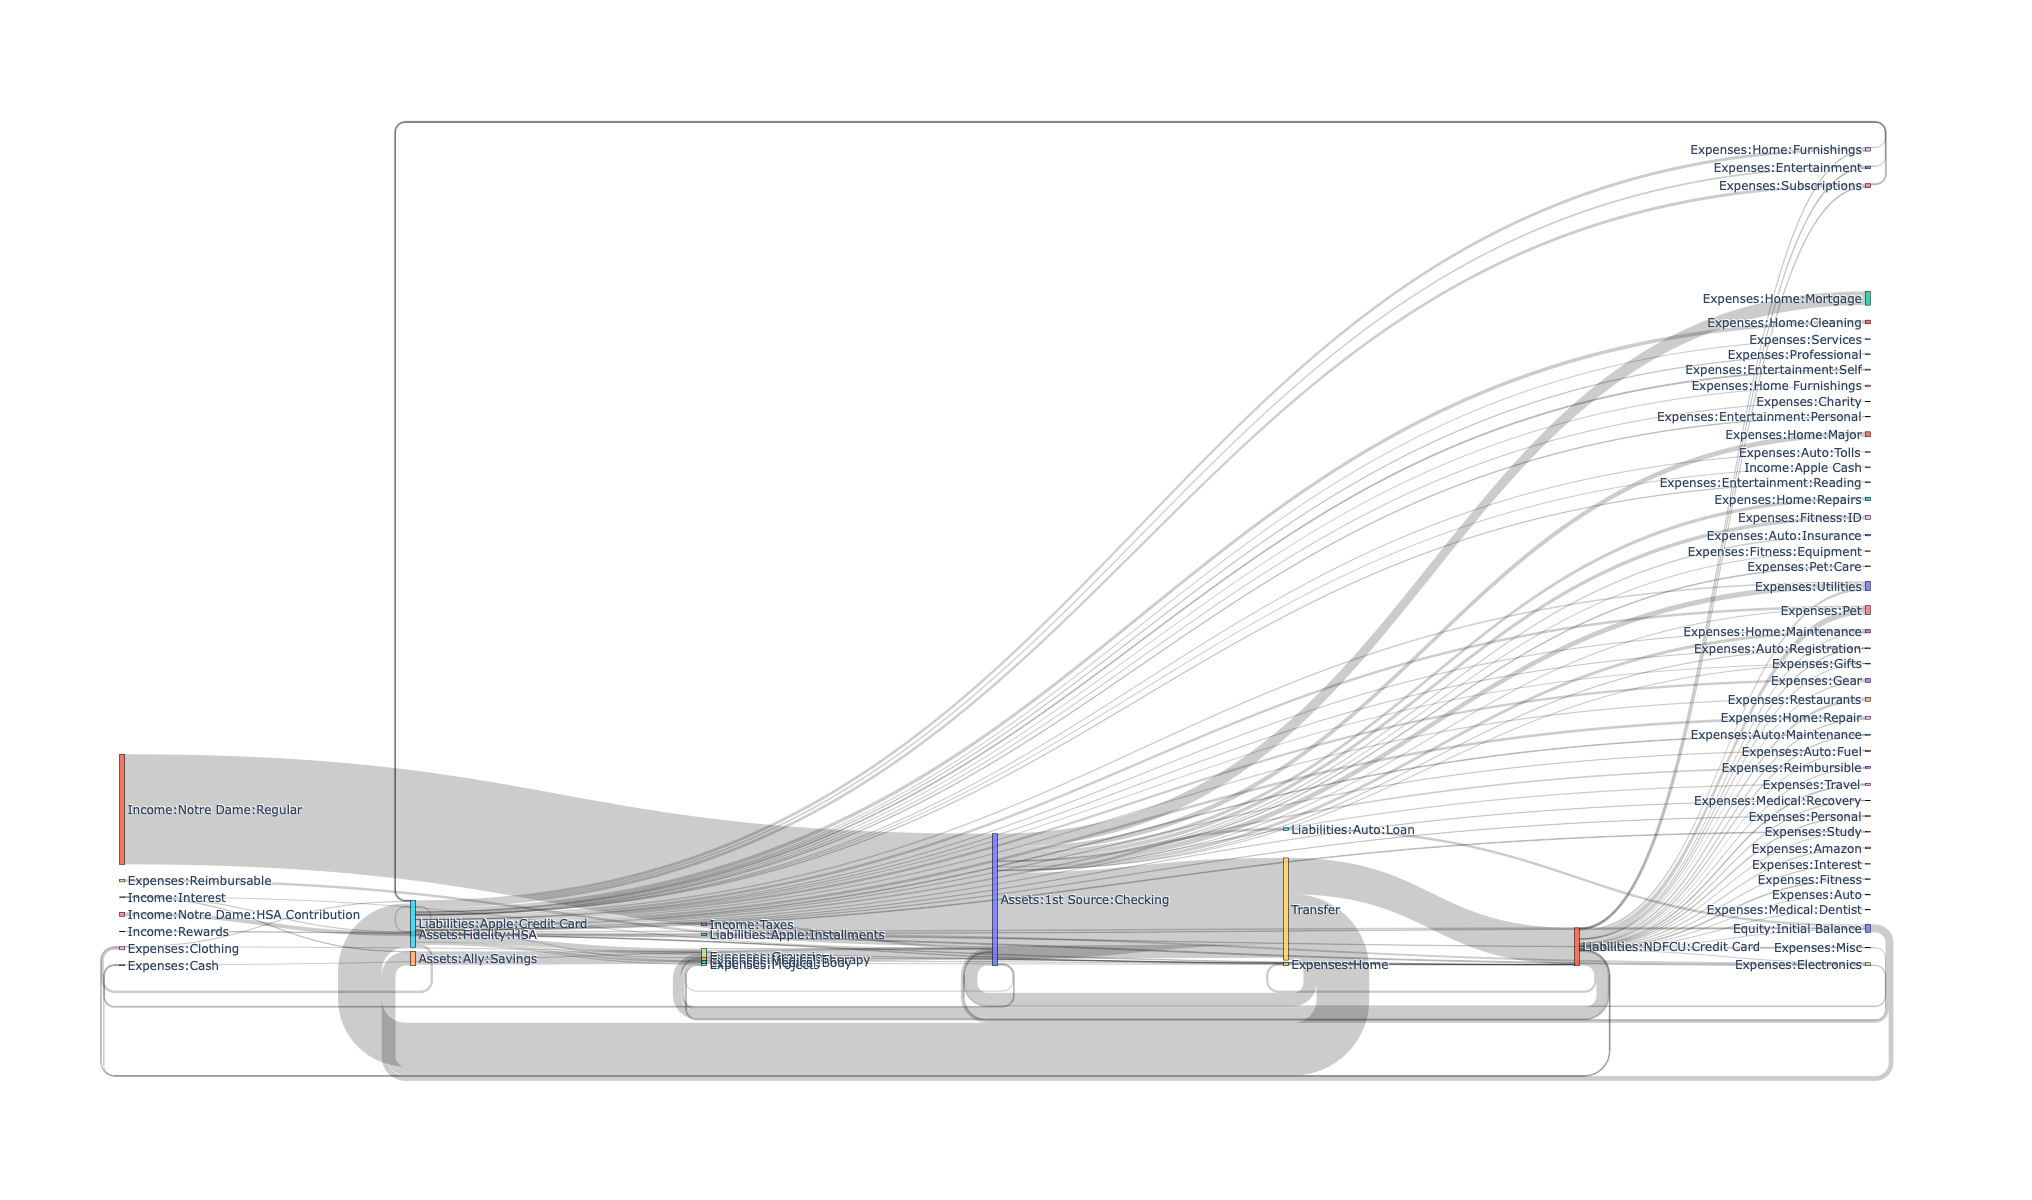

In [26]:
f.update_layout(height=1200)
f.show()

In [27]:
monthly_sum = lw0.groupby(ACCT_NAMES + ["Date"]).sum().groupby(ACCT_NAMES + [pd.Grouper(freq="ME", level=-1)])["Incoming Amount"].sum()
px.scatter(monthly_sum.loc[("Expenses", "Electronics", "")], y="Incoming Amount")

monthly_mean = monthly_sum.groupby(ACCT_NAMES).mean()

In [28]:
monthly_mean

Type         Account          Subaccount  
Assets       1st Source       Checking        181.87
             Ally             Savings          43.97
             Fidelity         HSA             200.62
Equity       Initial Balance                 -120.89
Expenses     Amazon                            77.89
                                               ...  
Liabilities  Apple            Credit Card    -100.72
                              Installments    -20.20
             Auto             Loan             -0.00
             NDFCU            Credit Card     -35.22
Transfer                                     -107.02
Name: Incoming Amount, Length: 64, dtype: float64

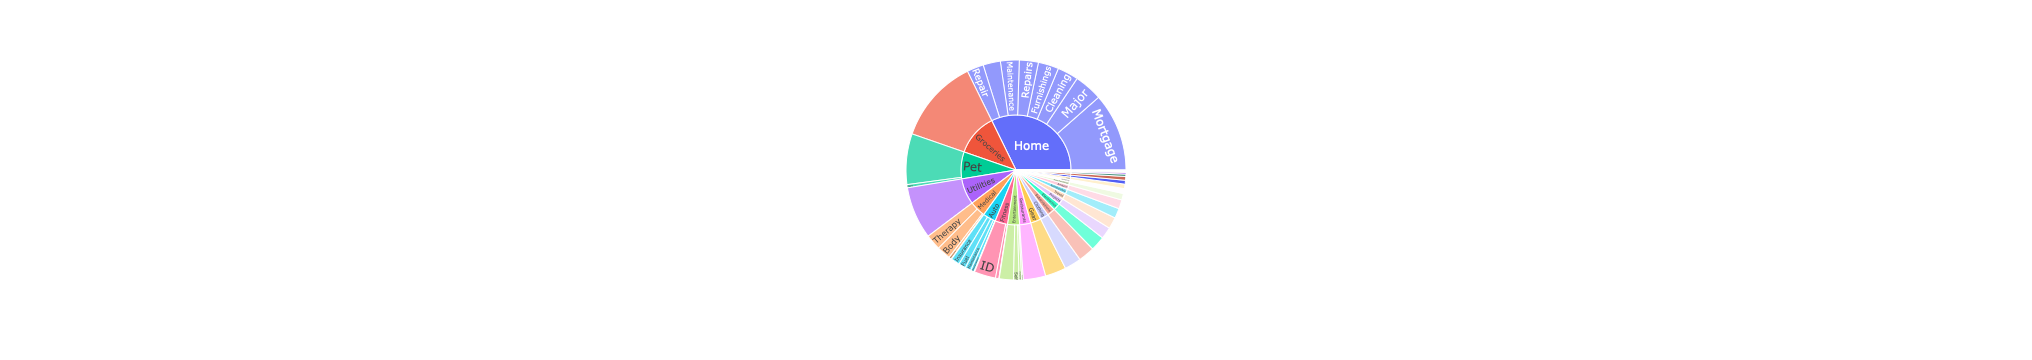

In [29]:
mean_expenses = monthly_mean["Expenses"]
remaining = mean_expenses.sum() + monthly_mean["Income"].sum()
monthly = pd.concat([mean_expenses, pd.Series(data=-1 * remaining, index=pd.MultiIndex.from_tuples([("Remaining", "", "")]))], axis="rows")
monthly.index.names=["Account", "Subaccount"]
monthly.name="Total"
px.sunburst(monthly.reset_index(), path=["Account", "Subaccount"], values="Total")

In [30]:
trans[trans.From == "Expenses:Utilities"]

Date                                        Description  Amount  \
17   2022-01-05  AMZN MKTP US*ET0DT6QC3   . AMZN.COM/BILL. WA 0000  -17.12   
25   2022-01-12                          VERIZON WIRELESS PAYMENTS -107.88   
30   2022-01-14                          AEP INDIANA MICH BILL PAY -101.15   
33   2022-01-14  CITY OF SOUTH BEND       . 574-223-0311 . IN 0000  -88.80   
37   2022-01-16  AMZN MKTP US*HU2BX13K3   . AMZN.COM/BILL. WA 0000  -85.96   
...         ...                                                ...     ...   
2905 2024-08-08  CITY OF SOUTH BEND 227 WEST JEFFERSON BLVD STE... -184.47   
2914 2024-08-09                          VERIZON WIRELESS PAYMENTS -114.64   
2917 2024-08-12                            NIPSCO ACCOUNTS BILLPAY  -22.80   
2921 2024-08-14                          AEP INDIANA MICH BILL PAY -118.04   
2927 2024-08-19  COMCAST CHICAGO          . 800-COMCAST  . IL 0000 -107.05   

                    From                             To  
17    Expenses:Utilities  Liabilities:NDFCU:Credit Card  
25    Expenses:Utilities     Assets:1st Source:Checking  
30    Expenses:Utilities     Assets:1st Source:Checking  
33    Expenses:Utilities  Liabilities:NDFCU:Credit Card  
37    Expenses:Utilities  Liabilities:NDFCU:Credit Card  
...                  ...                            ...  
2905  Expenses:Utilities  Liabilities:Apple:Credit Card  
2914  Expenses:Utilities     Assets:1st Source:Checking  
2917  Expenses:Utilities     Assets:1st Source:Checking  
2921  Expenses:Utilities     Assets:1st Source:Checking  
2927  Expenses:Utilities  Liabilities:NDFCU:Credit Card  

[191 rows x 5 columns]

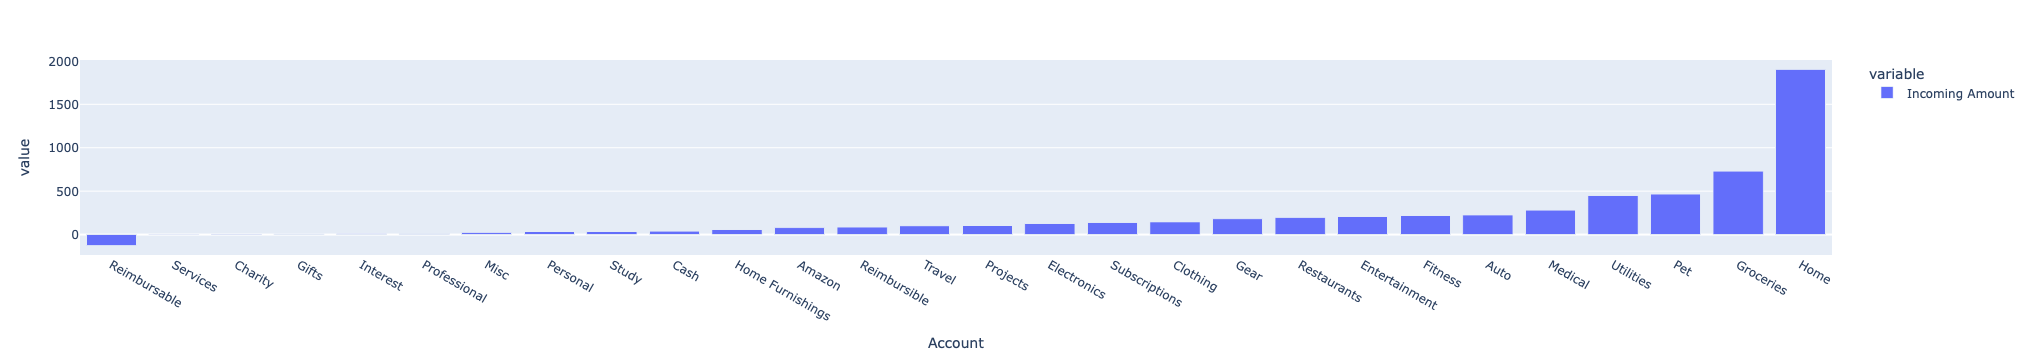

In [31]:
df = monthly_mean["Expenses"].groupby(["Account"]).sum().sort_values()
px.bar(df)

In [32]:
pmsum = monthly_sum["Expenses"]#.reset_index()
#pmsum["Acctstr"] = pmsum["Account"] + ":" + pmsum["Subaccount"]
#pmsum["Date"] = pmsum["Date"].astype(object).apply(pd.Period.to_timestamp)

In [33]:
pmsum=pmsum.reorder_levels(["Date", "Account", "Subaccount"])

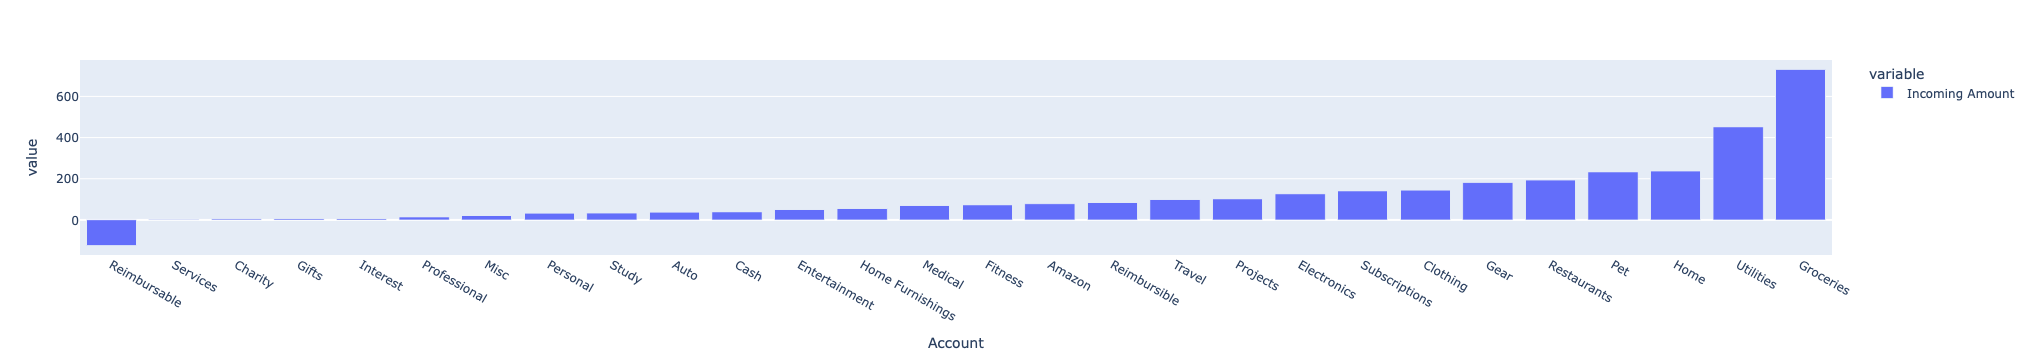

In [34]:
df = monthly_sum["Expenses"]
#px.bar(df.sort_values())
df = df.groupby("Account").mean()
px.bar(df.sort_values())

In [35]:
pdextension = pd.period_range(start = pmsum.index.levels[0][-1], end=pd.Period("2024-12"), freq="M")[1:]

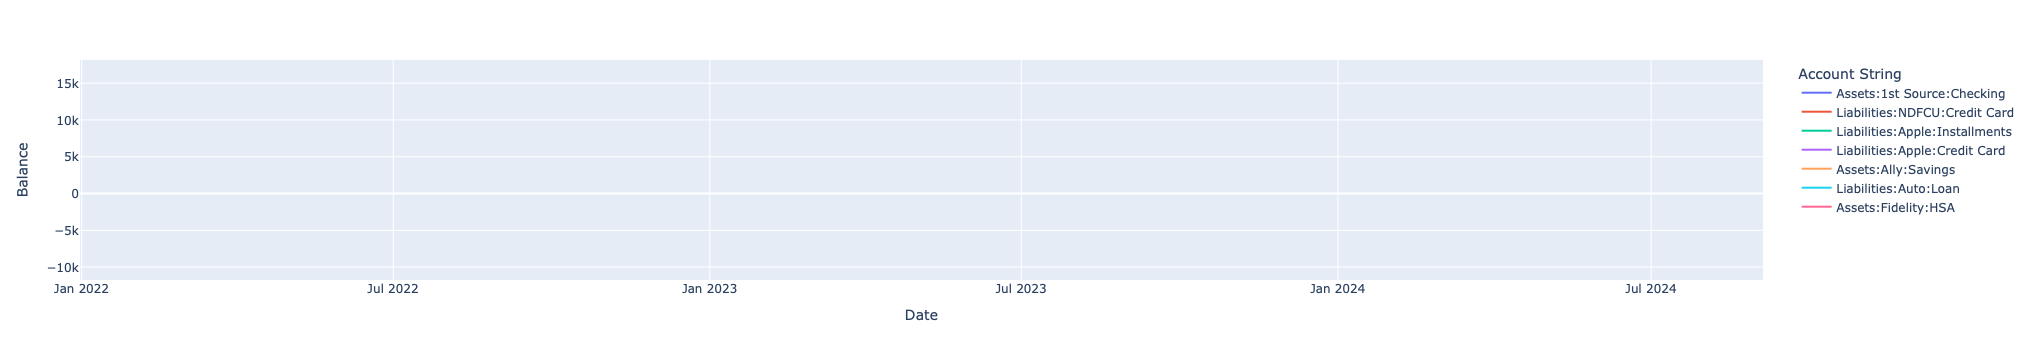

In [36]:
px.line(ledgers[ledgers["Type"].isin(["Assets", "Liabilities"])], x="Date", y="Balance", color="Account String")

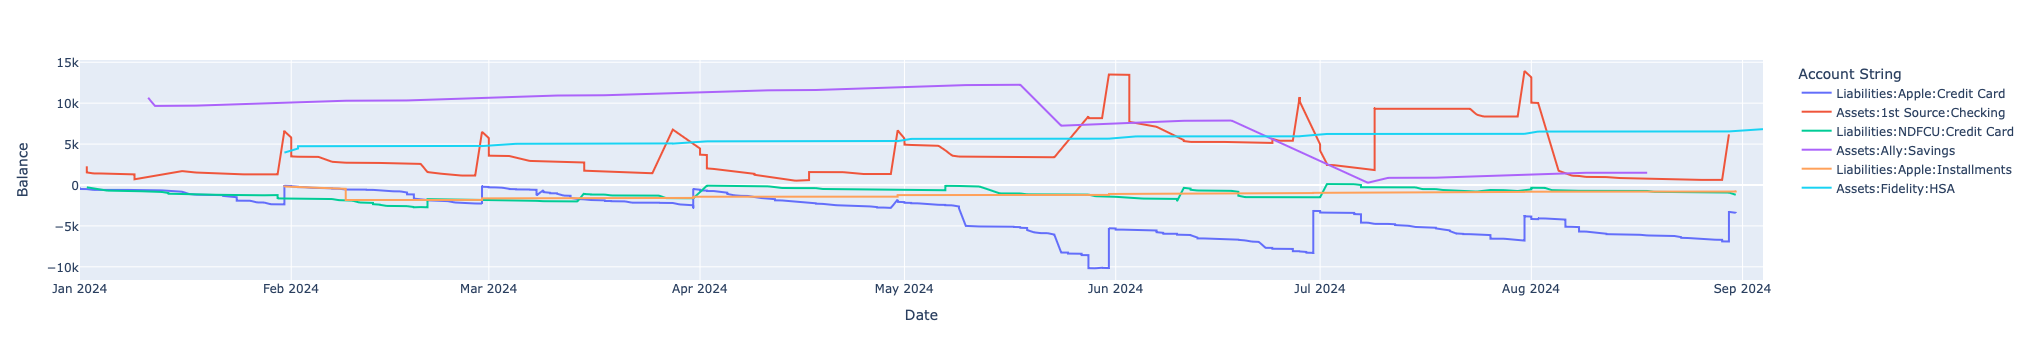

In [37]:
exp = ledgers[ledgers["Type"].isin(["Assets", "Liabilities"])]
px.line(exp[exp["Date"] >= pd.Timestamp(2024, 1, 1)], x="Date", y="Balance", color="Account String")

In [38]:
budget = {}
for idx in pdextension:
    budget[idx] = monthly_mean
budget = pd.DataFrame(budget)

In [39]:
btrans = pd.DataFrame(budget.T.stack(["Account", "Subaccount"])).rename(columns={0:"Amount"})
#help(btrans.index)
#btrans["Account String"] = [":".join(("Expenses", a, b)) for a, b in zip(btrans.index.get_level_values("Account"),
#                                                           btrans.index.get_level_values("Subaccount"))]
#btrans=btrans.droplevel("Account")
#btrans=btrans.droplevel("Subaccount")

#def stripcolon(s):
#    if s.endswith(":"):
#        return s[:-1]
#    else:
#        return s
#btrans["To"] = btrans["Account String"].apply(stripcolon)

/var/folders/42/qqsltqsj6fl30wl4xm41gs4m0000gn/T/ipykernel_81339/1351139105.py:1: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.



In [40]:
endassets = br.loc["Assets"]["End Balance"]
endliabilities = br.loc["Liabilities"]["End Balance"]

In [41]:
start = pd.DataFrame(pd.concat([endassets, endliabilities])).rename(columns={"End Balance": "Balance"})

In [42]:
start["Description"] = "Ending Balance"

In [43]:
expsum = btrans.groupby(level=0).sum()
#expsum["Balance"] = expsum.cumsum()

In [44]:
expsum

Type     Assets  Equity  Expenses    Income  Liabilities  Transfer
2024-10  426.47 -120.89  5,715.15 -5,757.59      -156.13   -107.02
2024-11  426.47 -120.89  5,715.15 -5,757.59      -156.13   -107.02
2024-12  426.47 -120.89  5,715.15 -5,757.59      -156.13   -107.02

In [45]:
dfs = {}
keep = ["Date", "Description", "Account String"]
accts = []
for typ in ["Assets", "Liabilities", "Transfer"]:
    accts.append(pd.unique(ledgers[ledgers["Type"] == typ]["Account String"]))
accts = np.concatenate(accts)

bals = []
grouped = ledgers.groupby("Account String")
for acct in accts:
    bals.append(grouped.get_group(acct)["Balance"].rename("Balance " + acct))

balance_table=pd.concat([ledgers[keep], pd.concat(bals, axis="columns")], join="inner", axis="columns").sort_values("Date").ffill().fillna(0)

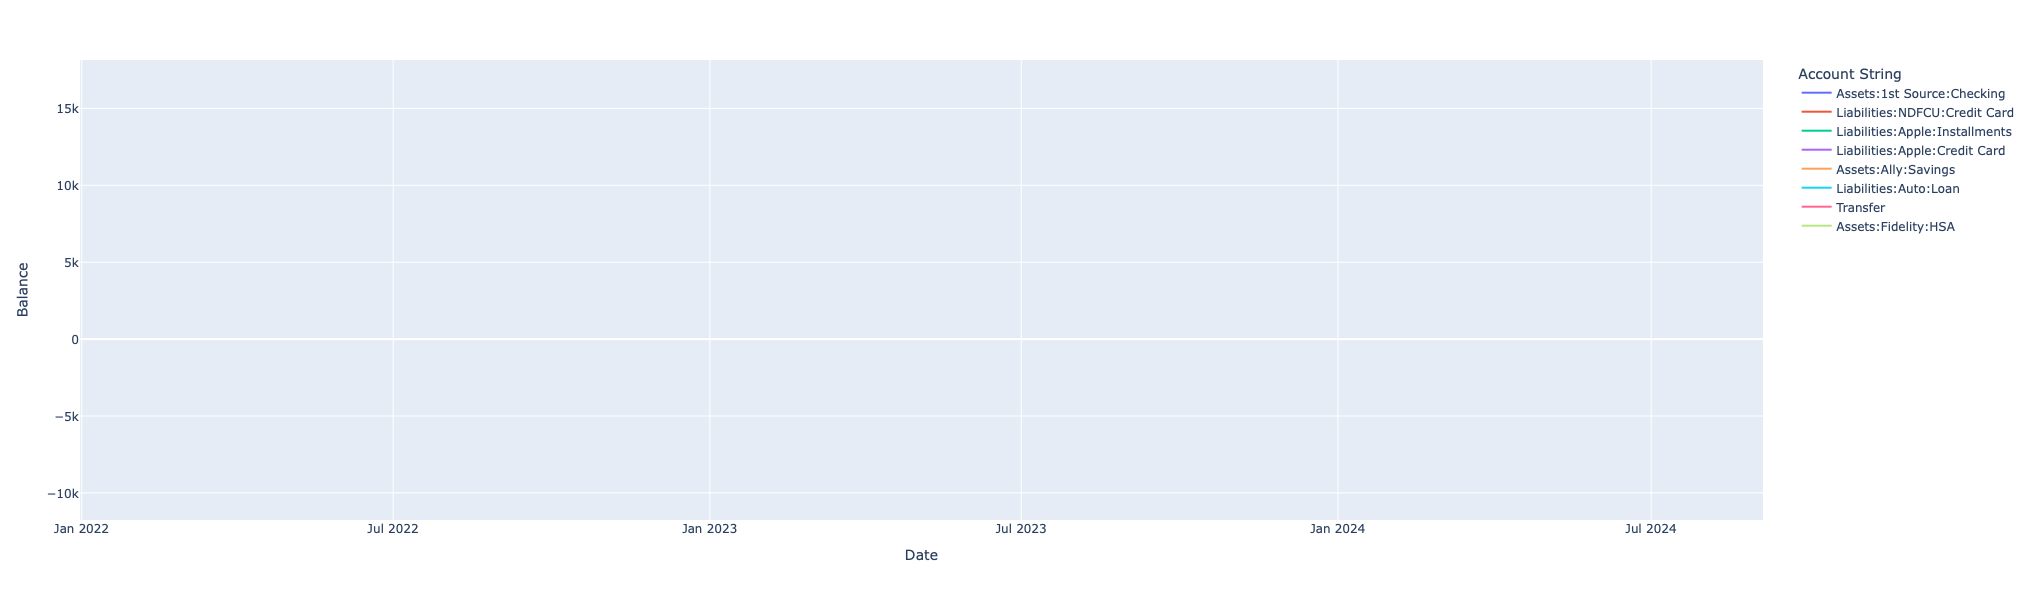

In [46]:
px.line(ledgers[ledgers["Type"].isin(["Assets", "Liabilities", "Transfer"])].set_index("Date"),
        y="Balance", color="Account String", height=600)

In [47]:
pd.set_option('display.max_rows', 100, 'display.max_columns', None)

In [48]:
asgrouped = ledgers.groupby("Account String")["Incoming Amount"].sum()
asgrouped.name="Asset String"
tpgrouped = ledgers.groupby("Transaction Pair")["Incoming Amount"].sum()
tpgrouped.name="Transaction Pair"

In [49]:
pd.options.display.float_format = '{:,.2f}'.format


check = pd.concat([asgrouped,-1 *  tpgrouped], axis="columns")#.rename(columns={"Incoming Amount"Asset String", 1:"Transaction Pair"})

In [82]:
check

Asset String  Transaction Pair
Assets:1st Source:Checking              6,183.68          6,183.68
Assets:Ally:Savings                     1,495.04          1,495.04
Assets:Fidelity:HSA                     6,821.21          6,821.21
Equity:Initial Balance                 -4,110.17         -4,110.17
Expenses:Amazon                         2,648.20          2,648.20
Expenses:Auto                               9.62              9.62
Expenses:Auto:Fuel                      2,135.99          2,135.99
Expenses:Auto:Insurance                 2,569.32          2,569.32
Expenses:Auto:Maintenance               1,720.86          1,720.86
Expenses:Auto:Registration              1,033.69          1,033.69
Expenses:Auto:Tolls                       162.44            162.44
Expenses:Cash                           1,308.50          1,308.50
Expenses:Charity                          159.20            159.20
Expenses:Clothing                       4,912.15          4,912.15
Expenses:Electronics                    4,286.89          4,286.89
Expenses:Entertainment                  4,162.89          4,162.89
Expenses:Entertainment:Personal           768.23            768.23
Expenses:Entertainment:Reading            464.81            464.81
Expenses:Entertainment:Self             1,617.11          1,617.11
Expenses:Fitness                          998.00            998.00
Expenses:Fitness:Equipment                100.00            100.00
Expenses:Fitness:ID                     6,300.00          6,300.00
Expenses:Gear                           6,135.25          6,135.25
Expenses:Gifts                            227.52            227.52
Expenses:Groceries                     24,802.89         24,802.89
Expenses:Home                           5,089.56          5,089.56
Expenses:Home Furnishings               1,916.29          1,916.29
Expenses:Home:Cleaning                  6,155.00          6,155.00
Expenses:Home:Furnishings               6,022.89          6,022.89
Expenses:Home:Maintenance               5,512.36          5,512.36
Expenses:Home:Major                     8,284.00          8,284.00
Expenses:Home:Mortgage                 22,970.90         22,970.90
Expenses:Home:Repair                    4,894.82          4,894.82
Expenses:Home:Repairs                   5,600.00          5,600.00
Expenses:Interest                         263.97            263.97
Expenses:Medical:Body                   4,053.63          4,053.63
Expenses:Medical:Dentist                  114.00            114.00
Expenses:Medical:Recovery                 775.97            775.97
Expenses:Medical:Therapy                4,595.64          4,595.64
Expenses:Misc                             698.52            698.52
Expenses:Personal                       1,105.13          1,105.13
Expenses:Pet                           14,891.77         14,891.77
Expenses:Pet:Care                         935.00            935.00
Expenses:Professional                     475.88            475.88
Expenses:Projects                       3,456.23          3,456.23
Expenses:Reimbursable                  -4,184.19         -4,184.19
Expenses:Reimbursible                   2,907.51          2,907.51
Expenses:Restaurants                    6,576.68          6,576.68
Expenses:Services                          59.95             59.95
Expenses:Study                          1,126.42          1,126.42
Expenses:Subscriptions                  4,773.96          4,773.96
Expenses:Travel                         3,371.05          3,371.05
Expenses:Utilities                     15,348.74         15,348.74
Income:Apple Cash                          26.06             26.06
Income:Interest                          -818.34           -818.34
Income:Notre Dame:HSA Contribution     -6,583.20         -6,583.20
Income:Notre Dame:Regular            -183,763.08       -183,763.08
Income:Rewards                           -748.37           -748.37
Income:Taxes                           -3,871.00         -3,871.00
Liabilities:Appl

In [83]:
check[check["Asset String"] != check["Transaction Pair"]].assign(Diff=check["Asset String"] - check["Transaction Pair"])

Asset String  Transaction Pair  Diff
Equity:Initial Balance             -4,110.17         -4,110.17  0.00
Liabilities:Apple:Credit Card      -3,424.48         -3,424.48  0.00
Liabilities:Apple:Installments       -686.69           -686.69 -0.00
Liabilities:NDFCU:Credit Card      -1,197.33         -1,197.33  0.00

In [51]:
final_balance = ledgers.groupby(ACCT_NAMES)["Incoming Amount"].sum()

In [52]:
monthly_incoming = lw0.set_index(["Date"]).sort_index().groupby(ACCT_NAMES).resample("ME")["Incoming Amount"].sum()

In [53]:
this_year_inc = monthly_incoming.loc[(slice(None), slice(None), slice(None), slice(pd.Timestamp("2023-12-31"), pd.Timestamp("2024-05-31")))]

In [54]:
end_of_2023_bals = lw0.set_index(["Date"]).sort_index()[:pd.Timestamp("2023-12-31")].groupby(ACCT_NAMES)["Incoming Amount"].sum()

In [55]:
meaningful_eo23_bals = end_of_2023_bals.loc[["Assets", "Liabilities", "Transfer"]]

In [56]:
meaningful_eo23_bals

Type         Account     Subaccount  
Assets       1st Source  Checking        2,320.49
             Ally        Savings        10,058.08
             Fidelity    HSA             3,939.33
Liabilities  Apple       Credit Card      -284.77
                         Installments     -249.80
             Auto        Loan               -0.00
             NDFCU       Credit Card      -186.72
Transfer                                     0.00
Name: Incoming Amount, dtype: float64

In [57]:
budget.loc[["Income"]]

2024-10   2024-11   2024-12
Type   Account    Subaccount                                    
Income Apple Cash                       0.77      0.77      0.77
       Interest                       -24.07    -24.07    -24.07
       Notre Dame HSA Contribution   -193.62   -193.62   -193.62
                  Regular          -5,404.80 -5,404.80 -5,404.80
       Rewards                        -22.01    -22.01    -22.01
       Taxes                         -113.85   -113.85   -113.85

In [58]:
tot_exp_2024_to_date=this_year_inc["Expenses"].sum()
print(tot_exp_2024_to_date)

38030.05

In [59]:
tot_inc_2024_to_date=this_year_inc["Income"].sum()
print(-1*tot_inc_2024_to_date)

35578.689999999995

In [60]:
-1 * tot_inc_2024_to_date - tot_exp_2024_to_date

-2451.360000000008

In [61]:
meaningful_eo23_bals

Type         Account     Subaccount  
Assets       1st Source  Checking        2,320.49
             Ally        Savings        10,058.08
             Fidelity    HSA             3,939.33
Liabilities  Apple       Credit Card      -284.77
                         Installments     -249.80
             Auto        Loan               -0.00
             NDFCU       Credit Card      -186.72
Transfer                                     0.00
Name: Incoming Amount, dtype: float64

In [62]:
final_balance.loc[["Assets", "Liabilities", "Transfer"]]

Type         Account     Subaccount  
Assets       1st Source  Checking        6,183.68
             Ally        Savings         1,495.04
             Fidelity    HSA             6,821.21
Liabilities  Apple       Credit Card    -3,424.48
                         Installments     -686.69
             Auto        Loan               -0.00
             NDFCU       Credit Card    -1,197.33
Transfer                                -3,638.57
Name: Incoming Amount, dtype: float64

In [63]:
final_balance.loc[["Assets", "Liabilities", "Transfer"]].sum() - meaningful_eo23_bals.sum()

-10043.750000000005

In [64]:
rem_income = budget.loc[[("Income", "Notre Dame", "Regular"), ("Income", "Apple Cash", "")]]
rem_income

2024-10   2024-11   2024-12
Type   Account    Subaccount                              
Income Notre Dame Regular    -5,404.80 -5,404.80 -5,404.80
       Apple Cash                 0.77      0.77      0.77

In [65]:
budget[pd.Period("2024-10")].loc[("Expenses", "Amazon")]

Subaccount
   77.89
Name: 2024-10, dtype: float64

In [66]:
budget

2024-10   2024-11   2024-12
Type        Account          Subaccount                                    
Assets      1st Source       Checking            181.87    181.87    181.87
            Ally             Savings              43.97     43.97     43.97
            Fidelity         HSA                 200.62    200.62    200.62
Equity      Initial Balance                     -120.89   -120.89   -120.89
Expenses    Amazon                                77.89     77.89     77.89
            Auto                                   0.28      0.28      0.28
                             Fuel                 62.82     62.82     62.82
                             Insurance            75.57     75.57     75.57
                             Maintenance          50.61     50.61     50.61
                             Registration         30.40     30.40     30.40
                             Tolls                 4.78      4.78      4.78
            Cash                                  38.49     38.49     38.49
            Charity                                4.68      4.68      4.68
            Clothing                             144.47    144.47    144.47
            Electronics                          126.09    126.09    126.09
            Entertainment                        122.44    122.44    122.44
                             Personal             22.59     22.59     22.59
                             Reading              13.67     13.67     13.67
                             Self                 47.56     47.56     47.56
            Fitness                               29.35     29.35     29.35
                             Equipment             2.94      2.94      2.94
                             ID                  185.29    185.29    185.29
            Gear                                 180.45    180.45    180.45
            Gifts                                  6.69      6.69      6.69
            Groceries                            729.50    729.50    729.50
            Home                                 149.69    149.69    149.69
                             Cleaning            181.03    181.03    181.03
                             Furnishings         177.14    177.14    177.14
                             Maintenance         162.13    162.13    162.13
                             Major               243.65    243.65    243.65
                             Mortgage            675.61    675.61    675.61
                             Repair              143.97    143.97    143.97
                             Repairs             164.71    164.71    164.71
            Home Furnishings                      56.36     56.36     56.36
            Interest                               7.76      7.76      7.76
            Medical          Body                119.22    119.22    119.22
                             Dentist               3.35      3.35      3.35
                             Recovery             22.82     22.82     22.82
                             Therapy             135.17    135.17    135.17
            Misc                                  20.54     20.54     20.54
            Personal                              32.50     32.50     32.50
            Pet                                  437.99    437.99    437.99
                             Care                 27.50     27.50     27.50
            Professional                          14.00     14.00     14.00
            Projects                             101.65    101.65    101.65
            Reimbursable                        -123.06   -123.06   -123.06
            Reimbursible                          85.51     85.51     85.51
            Restaurants                          193.43    193.43    193.43
            Services                               1.76      1.76      1.76
            Study                                 33.13     33.13     33.13
            Subscriptions                        140.41    140.41    140.41
            Travel  

In [67]:
trans.to_csv(PRODUCTSPTH / "transactions.csv")
len(trans)

2972

In [68]:
balance_table

Date                                        Description  \
0    2021-12-31                                    Initial Balance   
8    2021-12-31  PHILLIPS 66 - 0082 FIR   . MISHAWAKA    . IN 0000   
9    2021-12-31  MARTIN S SUPERMARKE      . SOUTHBEND    . IN 0000   
10   2021-12-31                                    Initial Balance   
11   2021-12-31  APPLE.COM/BILL ONE APPLE PARK WAY 866-712-7753...   
...         ...                                                ...   
5938 2024-08-31                     MONTHLY INSTALLMENTS (7 OF 12)   
5941 2024-08-31  CHEWY.COM                . 800-672-4399 . FL 0000   
5936 2024-08-31                     MONTHLY INSTALLMENTS (7 OF 12)   
5937 2024-08-31                     MONTHLY INSTALLMENTS (7 OF 12)   
5942 2024-09-04     PARTIC CONTR CURRENT PARTICIPANT CUR YR (Cash)   

                      Account String  Balance Assets:1st Source:Checking  \
0         Assets:1st Source:Checking                            5,067.54   
8      Liabilities:NDFCU:Credit Card                            5,067.54   
9      Liabilities:NDFCU:Credit Card                            5,067.54   
10    Liabilities:Apple:Installments                            5,067.54   
11     Liabilities:Apple:Credit Card                            5,067.54   
...                              ...                                 ...   
5938  Liabilities:Apple:Installments                            6,183.68   
5941   Liabilities:NDFCU:Credit Card                            6,183.68   
5936  Liabilities:Apple:Installments                            6,183.68   
5937   Liabilities:Apple:Credit Card                            6,183.68   
5942             Assets:Fidelity:HSA                            6,183.68   

      Balance Assets:Ally:Savings  Balance Assets:Fidelity:HSA  \
0                            0.00                         0.00   
8                            0.00                         0.00   
9                            0.00                         0.00   
10                           0.00                         0.00   
11                           0.00                         0.00   
...                           ...                          ...   
5938                     1,495.04                     6,542.05   
5941                     1,495.04                     6,542.05   
5936                     1,495.04                     6,542.05   
5937                     1,495.04                     6,542.05   
5942                     1,495.04                     6,821.21   

      Balance Liabilities:NDFCU:Credit Card  \
0                                      0.00   
8                                    -26.93   
9                                   -113.88   
10                                  -113.88   
11                                  -113.88   
...                                     ...   
5938                                -923.76   
5941                              -1,197.33   
5936                              -1,197.33   
5937                              -1,197.33   
5942                              -1,197.33   

      Balance Liabilities:Apple:Installments  \
0                                       0.00   
8                                       0.00   
9                                       0.00   
10                                   -552.08   
11                                   -552.08   
...                                      ...   
5938                                 -686.69   
5941                                 -686.69   
5936                                 -800.77   
5937                                 -800.77   
5942                                 -800.77   

      Balance Liabilities:Apple:Credit Card  Balance Liabilities:Auto:Loan  \
0                                      0.00                           0.00   
8                                      0.00                           0.00   
9                                      0.00                           0.00   
10        

In [69]:
ledgers.to_csv(PRODUCTSPTH / "ledgers.csv")


In [70]:
ty = ledgers[ledgers["Date"] >= pd.Timestamp(2024, 1, 1)]
ty["Month"] = ty["Date"].apply(lambda d: d.month)
ty = ty.sort_values("Date")
tyg = ty.groupby(["Type", "Account", "Subaccount", "Month"])["Incoming Amount"].sum()

In [71]:
print(len(tyg))
tyg.unstack()


265

Month                                              1         2         3  \
Type        Account       Subaccount                                       
Assets      1st Source    Checking          4,232.77    -65.24    280.69   
            Ally          Savings            -363.90    635.82    635.45   
            Fidelity      HSA                  16.76    797.39    300.41   
Expenses    Amazon                             14.99     17.98    125.05   
            Auto          Fuel                 40.37     80.40     47.26   
                          Insurance              NaN       NaN       NaN   
                          Maintenance            NaN       NaN       NaN   
                          Registration           NaN       NaN    231.42   
                          Tolls               127.50       NaN       NaN   
            Clothing                          481.50       NaN       NaN   
            Electronics                          NaN  1,648.00       NaN   
            Entertainment                      56.18    198.05    156.51   
                          Personal               NaN     19.95       NaN   
                          Reading              12.99      8.55       NaN   
                          Self                157.53     46.85     66.88   
            Fitness       ID                  225.00    225.00    225.00   
            Gear                              101.65       NaN    230.00   
            Gifts                             125.00       NaN       NaN   
            Groceries                         806.34    597.66    653.52   
            Home                              237.35       NaN     98.34   
                          Cleaning            278.00    278.00    278.00   
                          Furnishings            NaN       NaN       NaN   
                          Maintenance            NaN       NaN       NaN   
                          Major                  NaN       NaN       NaN   
                          Mortgage            746.58    746.58    746.58   
                          Repair                 NaN       NaN       NaN   
            Interest                            8.84     25.00     16.49   
            Medical       Body                107.35    115.04     84.84   
                          Recovery               NaN       NaN    255.94   
                          Therapy             132.46    273.08       NaN   
            Misc                                 NaN       NaN     79.00   
            Personal                             NaN     45.50     42.00   
            Pet                               542.78    126.27    308.52   
                          Care                   NaN    125.00       NaN   
            Projects                             NaN       NaN       NaN   
            Reimbursable                         NaN       NaN       NaN   
            Reimbursible                         NaN    597.89       NaN   
            Restaurants                       148.08    345.20    174.17   
            Services                             NaN       NaN     59.95   
            Study                              77.92     80.48     41.16   
            Subscriptions                     116.98    165.30    174.75   
            Travel                               NaN    107.10       NaN   
            Utilities                         562.61    541.18    393.33   
Income      Apple Cash                           NaN       NaN     18.90   
            Interest                          -52.95    -54.22    -56.87   
            Notre Dame    HSA Contribution       NaN   -779.16   -279.16   
                          Regular          -5,335.70 -5,335.70 -5,335.70   
            Rewards                           -76.50    -25.50       NaN   
            Taxes                                NaN       NaN       NaN   
Liabilities Apple         Credit Card         190.26   -119.86   -282.62   
                          Installments         6

In [72]:
ty

Date                                        Description  \
4412 2024-01-01  APPLE.COM/BILL ONE APPLE PARK WAY 866-712-7753...   
4429 2024-01-01  TRADE COFFEE CO 268 SUMMER ST. 6TH FLOOR BOSTO...   
4428 2024-01-01  APPLE.COM/BILL ONE APPLE PARK WAY 866-712-7753...   
4427 2024-01-01  APPLE.COM/BILL ONE APPLE PARK WAY 866-712-7753...   
4426 2024-01-01  APPLE.COM/BILL ONE APPLE PARK WAY 866-712-7753...   
...         ...                                                ...   
5939 2024-08-31  CHEWY.COM                . 800-672-4399 . FL 0000   
5940 2024-08-31                     MONTHLY INSTALLMENTS (7 OF 12)   
5941 2024-08-31  CHEWY.COM                . 800-672-4399 . FL 0000   
5942 2024-09-04     PARTIC CONTR CURRENT PARTICIPANT CUR YR (Cash)   
5943 2024-09-04     PARTIC CONTR CURRENT PARTICIPANT CUR YR (Cash)   

                        Transaction Pair  Incoming Amount  \
4412              Expenses:Subscriptions           -17.11   
4429       Liabilities:Apple:Credit Card            35.00   
4428       Liabilities:Apple:Credit Card             9.99   
4427       Liabilities:Apple:Credit Card             9.99   
4426       Liabilities:Apple:Credit Card            12.99   
...                                  ...              ...   
5939       Liabilities:NDFCU:Credit Card           273.57   
5940      Liabilities:Apple:Installments           -23.25   
5941                        Expenses:Pet          -273.57   
5942  Income:Notre Dame:HSA Contribution           279.16   
5943                 Assets:Fidelity:HSA          -279.16   

                          Account String         Type        Account  \
4412       Liabilities:Apple:Credit Card  Liabilities          Apple   
4429                  Expenses:Groceries     Expenses      Groceries   
4428              Expenses:Subscriptions     Expenses  Subscriptions   
4427              Expenses:Subscriptions     Expenses  Subscriptions   
4426              Expenses:Subscriptions     Expenses  Subscriptions   
...                                  ...          ...            ...   
5939                        Expenses:Pet     Expenses            Pet   
5940       Liabilities:Apple:Credit Card  Liabilities          Apple   
5941       Liabilities:NDFCU:Credit Card  Liabilities          NDFCU   
5942                 Assets:Fidelity:HSA       Assets       Fidelity   
5943  Income:Notre Dame:HSA Contribution       Income     Notre Dame   

            Subaccount   Balance  Month  
4412       Credit Card   -301.88      1  
4429                   19,206.41      1  
4428                    3,615.02      1  
4427                    3,605.03      1  
4426                    3,595.04      1  
...                ...       ...    ...  
5939                   14,891.77      8  
5940       Credit Card -3,424.48      8  
5941       Credit Card -1,197.33      8  
5942               HSA  6,821.21      9  
5943  HSA Contribution -6,583.20      9  

[1532 rows x 10 columns]

In [73]:
pd.Period("2024-01")

Period('2024-01', 'M')

In [74]:
"1,2,3".split(",")

['1', '2', '3']

In [75]:
bm = ledgers
bm["Period"] = bm["Date"].apply(lambda d: pd.Period(f"{d.year}-{d.month}"))
bm = bm.groupby(["Type", "Account", "Subaccount", "Period"], dropna=False ).tail(1)
bm = bm.sort_values(["Type", "Account", "Subaccount", "Period"])
bm = bm.set_index(["Type", "Account", "Subaccount", "Period"])["Balance"]
#bm.loc[["Assets"]]
bm.unstack().ffill(axis="columns")
#ledgers[ledgers["Subaccount"] == "Equipment"]

Period                                          2021-12   2022-01   2022-02  \
Type        Account          Subaccount                                       
Assets      1st Source       Checking          5,067.54  5,463.93  6,614.48   
            Ally             Savings           8,028.68  6,031.73  6,034.29   
            Fidelity         HSA                    NaN       NaN       NaN   
Equity      Initial Balance                   -8,326.88 -4,110.17 -4,110.17   
Expenses    Amazon                                  NaN    221.00    233.99   
            Auto                                    NaN      9.62      9.62   
                             Fuel                 26.93     59.06     92.07   
                             Insurance              NaN       NaN       NaN   
                             Maintenance            NaN       NaN     14.00   
                             Registration           NaN       NaN       NaN   
                             Tolls                  NaN       NaN       NaN   
            Cash                                    NaN    100.00    100.00   
            Charity                                 NaN       NaN       NaN   
            Clothing                                NaN     63.88     63.88   
            Electronics                             NaN       NaN       NaN   
            Entertainment                         11.04     28.04    143.43   
                             Personal               NaN       NaN     34.95   
                             Reading                NaN       NaN       NaN   
                             Self                   NaN       NaN       NaN   
            Fitness                                 NaN    225.00    548.00   
                             Equipment              NaN       NaN       NaN   
                             ID                     NaN       NaN       NaN   
            Gear                                    NaN    973.65  1,693.65   
            Gifts                                   NaN       NaN       NaN   
            Groceries                             86.95    619.31  1,274.10   
            Home                                    NaN      5.99     11.98   
                             Cleaning               NaN       NaN       NaN   
                             Furnishings            NaN       NaN       NaN   
                             Maintenance            NaN       NaN       NaN   
                             Major                  NaN       NaN       NaN   
                             Mortgage               NaN    674.34  1,348.68   
                             Repair                 NaN       NaN       NaN   
                             Repairs                NaN       NaN       NaN   
            Home Furnishings                        NaN       NaN       NaN   
            Interest                                NaN       NaN       NaN   
            Medical          Body                   NaN    560.86    647.03   
                             Dentist                NaN       NaN       NaN   
                             Recovery               NaN       NaN       NaN   
                             Therapy                NaN     70.00    140.00   
            Misc                                    NaN      9.16      9.16   
            Personal                                NaN     36.00     70.00   
            Pet                                     NaN    123.08    246.16   
                             Care                   NaN       NaN     90.00   
            Professional                            NaN       NaN       NaN   
            Projects                                NaN       NaN       NaN   
            Reimbursable                            NaN       NaN       NaN   
            Reimbursible                            NaN       NaN       NaN   
            Restaurants                             NaN       NaN     54.13   
            Services                              

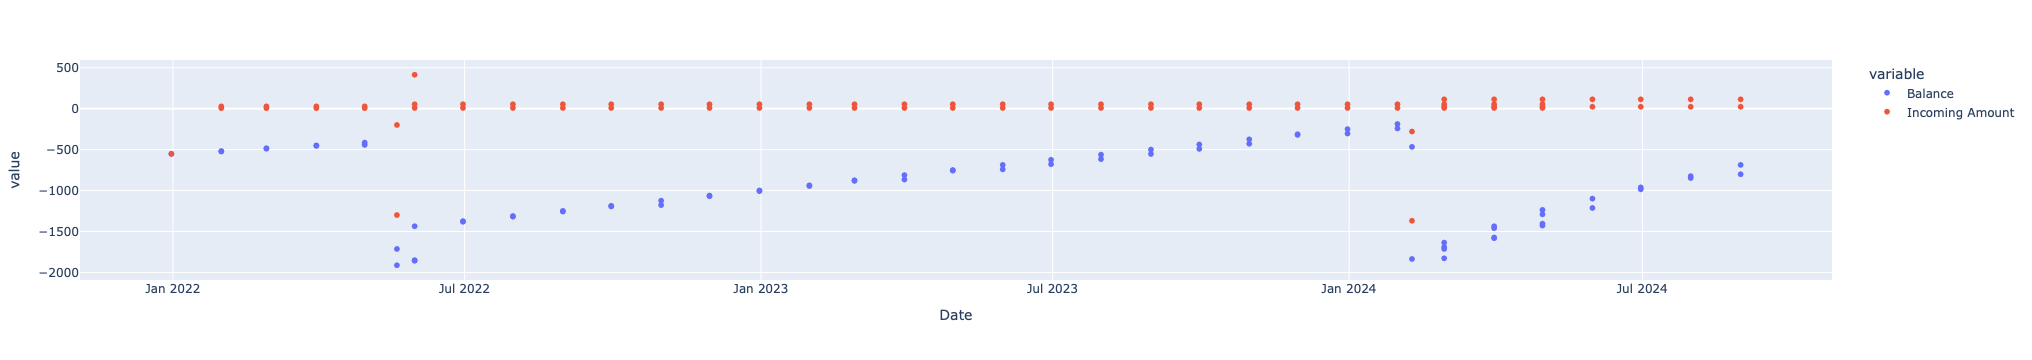

In [76]:
df = ledgers[ledgers["Subaccount"] == "Installments"]
fig = px.scatter(df, x="Date", y=["Balance", "Incoming Amount"])
fig.show()

In [77]:
trans[trans["Amount"].apply(abs) == 481.50]

Date         Description  Amount                  From  \
360 2022-05-20  DDA RTN APPLE STOR  481.50  Expenses:Electronics   

                             To  
360  Assets:1st Source:Checking

In [78]:
trans[trans["Amount"].apply(abs) == 414.12/inc/inc
]

NameError: name 'inc' is not defined

In [84]:
ledgers[ledgers["Account String"] == "Liabilities:NDFCU:Credit Card"].groupby("Period").tail(1)

Date                                        Description  \
15   2021-12-31                                    Initial Balance   
130  2022-01-30  NETFLIX.COM              . NETFLIX.COM  . CA 0000   
259  2022-02-28  NETFLIX.COM              . NETFLIX.COM  . CA 0000   
405  2022-03-31  ROSELAND ANIMAL HOSPIT   . SOUTHBEND    . IN 0000   
595  2022-04-30  NETFLIX.COM              . NETFLIX.COM  . CA 0000   
793  2022-05-31         For $3.009.71 FROM FIRST SOURC REQSTD 5/31   
947  2022-06-30  NETFLIX.COM              . NETFLIX.COM  . CA 0000   
1165 2022-07-31  TST* Silver Harbor Brew  . Saint Joseph . MI 0000   
1330 2022-08-31                                                      
1520 2022-09-30  Netflix.com              . netflix.com  . CA 0000   
1723 2022-10-31  REQSTD $1.641.95    FROM FIRST SOURCE BANK 878...   
1897 2022-11-30  REQSTD $1.669.09    FROM FIRST SOURCE BANK 878...   
2179 2022-12-31  AMZN Mktp US*5Q7LU0YS3   . Amzn.com/bill. WA 0000   
2345 2023-01-31                                                      
2497 2023-02-28                                                      
2682 2023-03-31  WHOLEFDS SBN #10482      . MISHAWAKA    . IN 0000   
2843 2023-04-30  Netflix.com              . netflix.com  . CA 0000   
3021 2023-05-31  CHIPOTLE 0808            . MISHAWAKA    . IN 0000   
3260 2023-06-30  LA ESPERANZA INC         . SOUTH BEND   . IN 0000   
3421 2023-07-31  REQSTD $3.147.60    FROM FIRST SOURCE BANK 878...   
3611 2023-08-31                                                      
3773 2023-09-30  NOTRE DAME WELLNESS CEN  . NOTRE DAME   . IN 0000   
3981 2023-10-30  Netflix.com              . netflix.com  . CA 0000   
4215 2023-11-30  MED*PREMISE HEAL         . BRENTWOOD    . TN 0...   
4410 2023-12-31  Netflix.com              . netflix.com  . CA 0000   
4579 2024-01-31                                                      
4796 2024-02-29  Netflix.com              . 408-5403700  . CA 0000   
4971 2024-03-31                                                      
5129 2024-04-26  LA ESPERANZA             . SOUTH BEND   . IN 0000   
5355 2024-05-29  AMZN Mktp US*485         . Amzn.com/bill. WA 0...   
5521 2024-06-22  LA ESPERANZA             . SOUTH BEND   . IN 0000   
5749 2024-07-30  Netflix.com              . netflix.com  . CA 0000   
5941 2024-08-31  CHEWY.COM                . 800-672-4399 . FL 0000   

            Transaction Pair  Incoming Amount                 Account String  \
15    Equity:Initial Balance        -1,694.49  Liabilities:NDFCU:Credit Card   
130       Expenses:Utilities           -13.99  Liabilities:NDFCU:Credit Card   
259       Expenses:Utilities           -15.49  Liabilities:NDFCU:Credit Card   
405             Expenses:Pet          -362.10  Liabilities:NDFCU:Credit Card   
595       Expenses:Utilities           -15.49  Liabilities:NDFCU:Credit Card   
793                 Transfer             0.00  Liabilities:NDFCU:Credit Card   
947       Expenses:Utilities           -15.49  Liabilities:NDFCU:Credit Card   
1165    Expenses:Restaurants           -44.63  Liabilities:NDFCU:Credit Card   
1330       Expenses:Interest           -13.88  Liabilities:NDFCU:Credit Card   
1520  Expenses:Subscriptions           -15.49  Liabilities:NDFCU:Credit Card   
1723                Transfer             0.00  Liabilities:NDFCU:Credit Card   
1897                Transfer             0.00  Liabilities:NDFCU:Credit Card   
2179           Expenses:Home           -30.90  Liabilities:NDFCU:Credit Card   
2345       Expenses:Interest            -6.76  Liabilities:NDFCU:Credit Card   
2497       Expenses:Interest            -5.33  Liabilities:NDFCU:Credit Card   
2682      Expenses:Groceries           -11.69  Liabilities:NDFCU:Credit Card   
2843  Expenses:Subscriptions           -15.49  Liabilities:NDFCU:Credit Card   
3021    Expenses:Restaurants           -15.78  Liabilities:NDFCU:Credit Card   
3260    Expenses:Restaurants           -17.18  Liabilities:NDFCU:Credit Card   
3421                Transfer  

In [80]:
ndfcu

Date            Note  \
0    2024-04-26  CC SALES DRAFT   
1    2024-04-23  CC SALES DRAFT   
2    2024-04-19  CC SALES DRAFT   
3    2024-04-18  CC SALES DRAFT   
4    2024-04-15  CC SALES DRAFT   
...         ...             ...   
1002 2022-01-02  CC SALES DRAFT   
1003 2022-01-02  CC SALES DRAFT   
1004 2022-01-01  CC SALES DRAFT   
1005 2021-12-31  CC SALES DRAFT   
1006 2021-12-31  CC SALES DRAFT   

                                            Description  Amount    Balance  \
0     LA ESPERANZA             . SOUTH BEND   . IN 0000  -48.65    $498.11   
1     AMZN Mktp US*D21         . Amzn.com/bill. WA 0...  -26.74    $449.46   
2     COMCAST CHICAGO          . 800-COMCAST  . IL 0000 -107.05    $422.72   
3     AMAZON PRIME*MM8         . amzn.com/bill. WA 0...   -2.99    $315.67   
4     Amazon Prime*0P5         . Amzn.com/bill. WA 0...  -14.99    $312.68   
...                                                 ...     ...        ...   
1002  CROSSFIT SOUTH BEND      . MISHAWAKA    . IN 0000  -38.00  $1,831.50   
1003  MARTIN S SUPERMARKE      . SOUTHBEND    . IN 0000  -47.38  $1,793.50   
1004  CVS/PHARMACY #08642      . SOUTH BEND   . IN 0000  -24.70  $1,746.12   
1005  PHILLIPS 66 - 0082 FIR   . MISHAWAKA    . IN 0000  -26.93  $1,721.42   
1006  MARTIN S SUPERMARKE      . SOUTHBEND    . IN 0000  -86.95  $1,694.49   

                       From  
0      Expenses:Restaurants  
1             Expenses:Home  
2        Expenses:Utilities  
3           Expenses:Amazon  
4           Expenses:Amazon  
...                     ...  
1002     Expenses:Groceries  
1003     Expenses:Groceries  
1004  Expenses:Medical:Body  
1005     Expenses:Auto:Fuel  
1006     Expenses:Groceries  

[1102 rows x 6 columns]

In [81]:
bal_decl

Date                         Account  Statement Balance
0  2024-08-31  Liabilities:Apple:Installments            -824.02
1  2024-08-31   Liabilities:Apple:Credit Card          -3,424.48
2  2024-04-18             Assets:Ally:Savings          11,604.81
3  2024-03-18             Assets:Ally:Savings          10,965.45
4  2024-02-18             Assets:Ally:Savings          10,330.00
5  2024-04-30   Liabilities:NDFCU:Credit Card            -501.39
6  2024-03-31   Liabilities:NDFCU:Credit Card          -1,570.40
7  2024-02-29   Liabilities:NDFCU:Credit Card          -1,758.27
8  2024-01-31   Liabilities:NDFCU:Credit Card          -1,565.79
9  2024-01-31             Assets:Fidelity:HSA           3,956.09
10 2024-08-31             Assets:Fidelity:HSA           6,524.05
11 2024-01-30      Assets:1st Source:Checking           1,297.66
12 2024-08-29      Assets:1st Source:Checking             622.49
13 2024-07-30      Assets:1st Source:Checking           8,365.45
14 2024-01-18             Assets:Ally:Savings           9,694.18
15 2022-12-07             Assets:Ally:Savings               0.00
16 2023-12-31   Liabilities:NDFCU:Credit Card             -99.77
17 2024-08-31   Liabilities:NDFCU:Credit Card          -1,315.17
18 2023-12-31  Liabilities:Apple:Installments            -312.21
19 2023-12-31   Liabilities:Apple:Credit Card            -284.77
20 2023-12-31             Assets:Fidelity:HSA           3,939.33
21 2022-12-31             Assets:Fidelity:HSA               0.00
22 2023-12-31      Assets:1st Source:Checking           2,320.59
23 2023-12-18             Assets:Ally:Savings          10,058.08
24 2024-08-18             Assets:Ally:Savings           1,495.04
25 2023-11-30   Liabilities:NDFCU:Credit Card          -2,085.08
26 2023-11-30   Liabilities:NDFCU:Credit Card          -2,085.08
27 2023-11-30  Liabilities:Apple:Installments            -374.62
28 2023-11-30   Liabilities:Apple:Credit Card            -201.50
29 2023-11-18             Assets:Ally:Savings           9,425.23
30 2023-10-31   Liabilities:NDFCU:Credit Card          -2,492.89
31 2023-10-31  Liabilities:Apple:Installments            -437.03
32 2023-10-31   Liabilities:Apple:Credit Card            -151.48
33 2023-10-18             Assets:Ally:Savings           8,793.47
34 2023-09-30   Liabilities:NDFCU:Credit Card          -1,581.47
35 2023-08-31   Liabilities:NDFCU:Credit Card             -69.79
36 2023-07-31   Liabilities:NDFCU:Credit Card          -3,172.26
37 2023-06-30   Liabilities:NDFCU:Credit Card          -1,409.14
38 2023-05-31   Liabilities:NDFCU:Credit Card            -351.48
39 2023-04-30   Liabilities:NDFCU:Credit Card          -3,924.01
40 2023-03-31   Liabilities:NDFCU:Credit Card          -2,519.52
41 2023-02-28   Liabilities:NDFCU:Credit Card            -885.51
42 2023-01-31   Liabilities:NDFCU:Credit Card          -1,376.20
43 2022-12-31   Liabilities:NDFCU:Credit Card             -76.69
44 2021-12-31   Liabilities:NDFCU:Credit Card          -1,694.49
45 2022-01-01           Liabilities:Auto:Loan          -4,216.71
46 2021-12-31  Liabilities:Apple:Installments            -552.08
47 2021-12-31   Liabilities:Apple:Credit Card          -2,522.77
48 2021-12-31      Assets:1st Source:Checking           5,067.54
49 2021-12-31             Assets:Ally:Savings           8,028.68